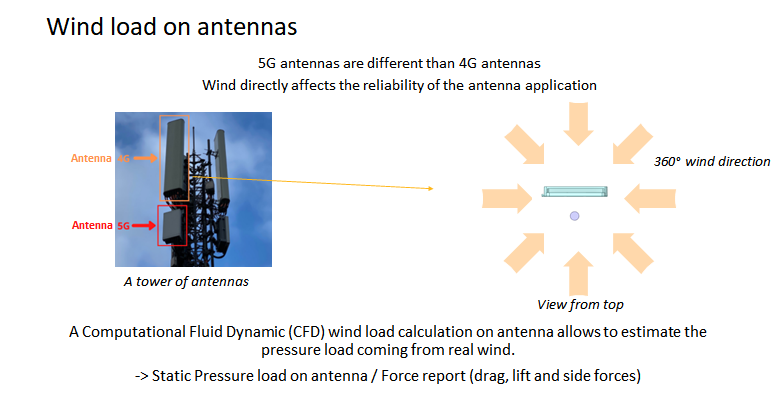

# Code design

* `WindLoad` instantiates `Meshing` and multiple `Solver`s containing business logic specific to the wind load use case
* Each workflow object maintains a Fluent session
* Everything is managed asynchronously with specific synchronization points as required
* Volume mesh created by `Meshing` is transferred to each solver sessions
 * Hides a file transfer operation which could be replaced by direct data streaming
* Different arguments are passed to each `Solver` (in this example only inlet velocity is varied)
* Lift force is computed by each solver
* PyFluent queries for the lift force from each solver and reports lift force for each inlet velocity

## APIs
* `Meshing` uses a generic API to access the meshing instantiation of Fluent's flexible workflow framework
* `Solver` uses a combination of APIs:
 * TUI-based API; the direct SchemeEval API; the new Settings API 



In [15]:
from ansys.fluent.core.async_execution import asynchronous

class Meshing:
    def __init__(self, launcher):
        self.session = launcher()
        self.workflow = self.session.workflow
        
    def initialize_workflow(self):
        self.workflow.initialize_workflow(workflow_type="Watertight Geometry")
        
    def import_geometry(self):
        import_geometry = self.workflow.task_object['Import Geometry']
        import_geometry.arguments.update_dict({"FileName":"E:/windload_geometry.scdoc.pmdb","AppendMesh":False})
        import_geometry.execute()
        
    def add_local_sizing(self):
        add_local_sizing = self.workflow.task_object['Add Local Sizing']
        add_local_sizing.arguments = {
            "AddChild":"yes", "BOIControlName":"face", "BOIExecution":"Body Size", 
            "BOIFaceLabelList":"farfield", "BOIZoneorLabel":"label"}
        add_local_sizing.execute()
        add_local_sizing.insert_compound_child_task()
        add_local_sizing.arguments.update_dict({"AddChild":"yes"})
        face = self.workflow.task_object['face']
        face.arguments.update_dict(
            {"AddChild":"yes", "BOIControlName":"refinementzone", "BOIExecution":"Body Size", 
             "BOIFaceLabelList":"meshrefinement", "BOISize":60}
        )
        
    def generate_surface_mesh(self):
        generate_surface_mesh = self.workflow.task_object['Generate the Surface Mesh']
        generate_surface_mesh.execute()
        generate_surface_mesh.insert_next_task(command_name='SurfaceMeshImprove')
        
    def improve_surface_mesh(self):
        improve_surface_mesh = self.workflow.task_object['Improve Surface Mesh']
        improve_surface_mesh.arguments.update_dict(
            {'FaceQualityLimit':0.7, 'MeshObject':'', 
             'SMImprovePreferences':{"SIQualityMaxAngle":160,"SIQualityIterations":5,"SIQualityCollapseLimit":0.85}}
        )
        improve_surface_mesh.execute()
        
    def describe_geometry(self):
        describe_geometry = self.workflow.task_object['Describe Geometry']
        describe_geometry.arguments.update_dict(
            {'CappingRequired':'No', 'InvokeShareTopology':'No', 
             'SetupInternalTypes': None, 'SetupInternals': None, 
             'SetupType': 'The geometry consists of both fluid and solid regions and/or voids', 
             'WallToInternal':'Yes'})
        describe_geometry.execute()
    
    def update_boundaries(self):
        self.workflow.task_object['Update Boundaries'].execute()
        
    def create_regions(self):
        create_regions = self.workflow.task_object['Create Regions']
        create_regions.arguments.update_dict({'NumberOfFlowVolumes':2})
        create_regions.execute()
        update_regions = self.workflow.task_object['Update Regions']
        update_regions.execute()
        
    def add_boundary_layers(self):
        add_boundary_layers = self.workflow.task_object['Add Boundary Layers']
        add_boundary_layers.add_child_to_task()
        add_boundary_layers.insert_compound_child_task()
        self.workflow.task_object['smooth-transition_1'].arguments.update_dict(
            {'BLControlName':'smooth-transition_1',
             'NumberOfLayers':10, 
             "OffsetMethodType":'smooth-transition',
             "transition_ratio":0.272}
        )
        add_boundary_layers.execute()
        
    def generate_volume_mesh(self):
        generate_volume_mesh = self.workflow.task_object['Generate the Volume Mesh']
        generate_volume_mesh.arguments.update_dict({'VolumeFill':'polyhedra'})
        generate_volume_mesh.execute()
        
        
    @asynchronous
    def run(self):
        self.initialize_workflow()
        self.import_geometry()
        self.add_local_sizing()
        self.generate_surface_mesh()
        self.improve_surface_mesh()
        self.describe_geometry()
        self.create_regions()
        self.update_boundaries()
        self.add_boundary_layers()
        self.generate_volume_mesh()
            

In [16]:
import os
from ansys.fluent.core.async_execution import asynchronous

@asynchronous
def run_solver(launcher, input_object):
    return Solver(
        launcher=launcher, 
        input_object=input_object or InputObject())


class SolverInput:
    def __init__(self):       
        self.hydraulic_diameter = 1.25
        self.density = 1.25
        self.inlet_velocity = 41.67
        self.unit_length = 0.001
        self.unit_width = 0.001
        self.turbulence_model_name = "ke-realizable"
        self.iteration_for_average_report = 1
        self.iterations_number = 10
        

class Solver:
    def __init__(self, launcher, input_object):
        self.session = launcher()
        self.solver = self.session.tui.solver
        self.api_root = self.session.get_settings_root()
        self.scheme_str_eval = self.session.scheme_eval.string_eval
        self.hydraulic_diameter = input_object.hydraulic_diameter
        self.density = input_object.density
        self.inlet_velocity = input_object.inlet_velocity
        self.unit_length = input_object.unit_length
        self.unit_width = input_object.unit_width
        self.turbulence_model_name = input_object.turbulence_model_name
        self.iteration_for_average_report = input_object.iteration_for_average_report
        self.iterations_number = input_object.iterations_number 
        self.lift = None   
    
    def calculate(self):
        self.solver.solve.iterate(self.iterations_number)
       
    def initialize(self):
        self.solver.solve.initialize.hyb_initialization()
       
    def create_report_definitions(self):
        
        report_cmds = [
          '(ti-menu-load-string (format #f "solve/report-definitions/add drag_unit lift average-over 1 scaled? no thread-names wallunit () q"))',
          '(ti-menu-load-string (format #f "solve/report-definitions/add c_d_unit lift average-over 1 scaled? yes thread-names wallunit () q"))',
          '(ti-menu-load-string (format #f "solve/report-definitions/add sideforce_unit drag average-over 1 scaled? no thread-names wallunit () q"))',
          '(ti-menu-load-string (format #f "solve/report-definitions/add c_s_unit drag average-over 1 scaled? yes thread-names wallunit () q"))'
        ]
        
        #map(self.scheme_str_eval, report_cmds)
        for cmd in report_cmds:
            self.scheme_str_eval(cmd)
        
        self.solver.define.parameters.output_parameters.create("report-definition", "drag_unit")
        self.solver.define.parameters.output_parameters.create("report-definition", "c_d_unit")
        self.solver.define.parameters.output_parameters.create("report-definition", "sideforce_unit")
        self.solver.define.parameters.output_parameters.create("report-definition", "c_s_unit")

    def set_discretization_scheme(self):
        self.solver.solve.set.discretization_scheme("k", 1)
        if self.turbulence_model_name == "ke-realizable":
            self.solver.solve.set.discretization_scheme("epsilon", 1)
        else:
            self.solver.solve.set.discretization_scheme("omega", 1)
        
    def set_up_reference_values(self):
        self.solver.report.reference_values.area(self.unit_length * self.unit_width)
        self.solver.report.reference_values.density(self.density)
        self.solver.report.reference_values.velocity(self.inlet_velocity)
        self.solver.report.reference_values.zone("farfield")
        
    def set_up_turbulence_model(self):
        if self.turbulence_model_name == "ke-realizable":
            self.solver.define.models.viscous.ke_realizable("yes")
            self.solver.define.models.viscous.near_wall_treatment.enhanced_wall_treatment("yes")
        if self.turbulence_model_name == "kw-sst":
            self.solver.define.models.viscous.kw_sst("yes")
        
    def set_up_boundary_conditions(self):
        reynolds = (self.density * self.inlet_velocity * self.hydraulic_diameter)/1.7894e-5
        turbulence_intensity = 0.16*pow(reynolds, -0.125)  
        inlet = self.api_root.setup.boundary_conditions.velocity_inlet['velocityinlet']
        inlet.turb_intensity = turbulence_intensity
        inlet.vmag.constant = self.inlet_velocity
        #inlet.turb_hydraulic_diam = self.hydraulic_diameter
             
        outlet = self.api_root.setup.boundary_conditions.pressure_outlet['pressureoutlet']
        outlet.turb_intensity = turbulence_intensity
        #outlet.turb_hydraulic_diam = self.hydraulic_diameter

    def set_up_materials(self):
        self.solver.define.materials.change_create("air", "air", "yes", "constant", self.density)
          
    def calculate_report_value(self):
        def parameter_table_str_to_dict(table: str) -> dict:
            # this code has become more complex now. Originally table was
            # str here - now ExecuteCommandResult is returned by the calls
            # to (in|out)put_parameters()
            table_str = table
            if not isinstance(table, str):
                try:
                    table_str = table.result
                except AttributeError as attr_err:
                    raise RuntimeError(
                        "Unexpected design point table "
                        f"type in parse: {type(table)}"
                    ) from attr_err
            data_lines = table_str.splitlines()[3:]
            table_as_dict = {}
            for line in data_lines:
                line_as_list = line.split()
                table_as_dict[line_as_list[0]] = line_as_list[1]
            return table_as_dict
       
        parameter_dict = parameter_table_str_to_dict(
           self.solver.define.parameters.list_parameters.output_parameters().result()
           )
        '''
        get_params_ti_cmd = '(ti-menu-load-string (format #f "define/parameters/list-parameters/output-parameters"))'
        parameter_dict_str = self.scheme_str_eval(get_params_ti_cmd)
        parameter_dict = parameter_table_str_to_dict(parameter_dict_str)
        '''
        return [self.inlet_velocity, parameter_dict["drag_unit-op"], parameter_dict["c_d_unit-op"], parameter_dict["sideforce_unit-op"], parameter_dict["c_s_unit-op"]]
    
        
    @asynchronous
    def run(self):
        self.set_up_materials()
        self.set_up_turbulence_model()
        self.set_up_boundary_conditions()
        self.set_up_reference_values()
        self.set_discretization_scheme()
        self.create_report_definitions()
        self.initialize()
        self.calculate()
        return self.calculate_report_value()


In [17]:
def transfer_mesh_from_meshing_to_solvers(meshing_session, solver_sessions):
    mesh_dir = os.getenv("TEMP") or os.getenv("TMP")
    if not isinstance(mesh_dir, str):
        mesh_dir = "."
    file_stem = "fluent_mesh_"
    file_ext = ".msh.cas.h5"
    for idx in range(100):
        file_name = file_stem + "_" + str(idx) + file_ext
        path = os.path.join(mesh_dir, file_name)
        if not os.path.isfile(path):
            meshing_session.tui.meshing.file.write_case(path).result()
            for solver_session in solver_sessions:
                solver_session.tui.solver.file.read_case(path)
            #os.remove(path)
            return
    raise RuntimeError("Could not write mesh to transfer")


In [18]:
import ansys.fluent as pyfluent
import pandas as pd

class WindLoad:
    def __init__(self, num_solves: int, inlet_velocity_expr:str):
        self.meshing = None
        self.solvers = []
        self.num_solves = num_solves
        self.inlet_velocity_expr = inlet_velocity_expr
        
    def __call__(self):
        self.meshing = Meshing(
            launcher=lambda : pyfluent.launch_fluent(meshing_mode=True)
        )
        meshing_run = self.meshing.run()
        for i in range(self.num_solves):
            input_object = SolverInput()
            input_object.inlet_velocity = eval(self.inlet_velocity_expr)
            solver = run_solver(
                launcher=pyfluent.launch_fluent, 
                input_object=input_object)
            self.solvers.append(solver)
        meshing_run.result() # sync step before mesh transfer
        transfer_mesh_from_meshing_to_solvers(
            self.meshing.session, 
            (solver.result().session for solver in self.solvers)
            )
        results = []
        for solver in self.solvers:
            results.append(solver.result().run())
        WindLoad._display_results(results)
        '''
        self.meshing_workflow.session.exit()
        for solver_workflow in self.solver_workflows:
            solver_workflow.result().session.exit()
        '''
        
    @classmethod
    def _display_results(cls, results):
        data0 = []
        data1 = []
        for result in results:
            values = result.result()
            data0.append(values[:3])
            values1 = [values[0], values[3], values[4]]
            data1.append(values1)
        frame0 = pd.DataFrame(data0, columns=["inlet velocity (m/s)", "lift (N)", "coefficient"])
        frame1 = pd.DataFrame(data1, columns=["inlet velocity (m/s)", "drag (N)", "coefficient"])
        print(frame0, '\n', frame1)
        frame0.plot.scatter(x="inlet velocity (m/s)", y="lift (N)")
        frame1.plot.scatter(x="inlet velocity (m/s)", y="drag (N)")
        

   inlet velocity (m/s)       lift (N)    coefficient
0                  35.0     -249.81438     -326288.17
1                  36.0      -264.9123     -327052.22
2                  37.0     -279.98179     -327224.88
3                  38.0     -295.63204     -327570.13
4                  39.0     -311.87734      -328076.1
5                  40.0      -328.6699      -328669.9
6                  41.0     -345.25186     -328615.69
7                  42.0     -362.88864      -329150.7
8                  43.0     -380.50348     -329262.07
9                  44.0  6.4385841e-27  5.3211439e-24 
    inlet velocity (m/s)        drag (N)     coefficient
0                  35.0       19.015906       24837.102
1                  36.0       20.110395       24827.649
2                  37.0       21.171652       24744.078
3                  38.0       22.230811       24632.478
4                  39.0       23.411077       24627.036
5                  40.0       24.546633       24546.633
6           

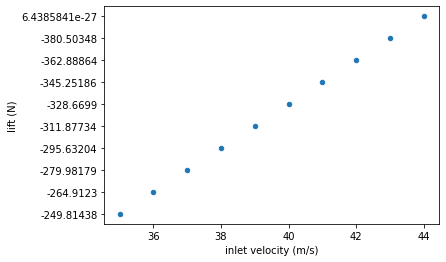

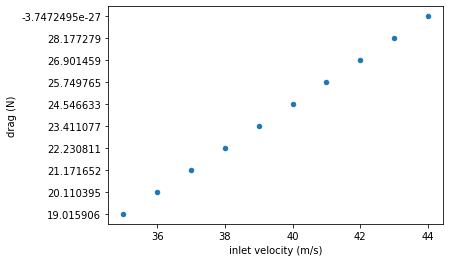

In [19]:
windld = WindLoad(10, "35.0 + 1.0 * i")
windld()

In [20]:
meshing = windld.meshing
meshing_session = meshing.session
meshing_workflow = meshing_session.workflow
meshing_workflow()

{'workflow': {'task_list': item: "TaskObject1"
  item: "TaskObject2"
  item: "TaskObject3"
  item: "TaskObject13"
  item: "TaskObject4"
  item: "TaskObject9"
  item: "TaskObject10"
  item: "TaskObject11",
  'current_task': None},
 'task_object:_task_object8': {'task_list': [],
  'command_name': 'CreateRegions',
  'warnings': None,
  'object_path': '',
  'errors': None,
  'task_type': 'Simple',
  'name_': 'Create Regions',
  'arguments': {'number_of_flow_volumes': 2},
  'state': 'Up-to-date',
  'inactive_task_list': []},
 'task_object:_task_object13': {'object_path': '',
  'state': 'Up-to-date',
  'arguments': {'s_m_improve_preferences': {'s_i_quality_iterations': 5,
    's_i_quality_collapse_limit': 0.85,
    's_i_quality_max_angle': 160},
   'face_quality_limit': 0.7,
   'mesh_object': ''},
  'inactive_task_list': [],
  'task_list': [],
  'warnings': None,
  'errors': None,
  'command_name': 'ImproveSurfaceMesh',
  'task_type': 'Simple',
  'name_': 'Improve Surface Mesh'},
 'task_obje

In [21]:
meshing_workflow.task_object['Import Geometry'].arguments()
dir(meshing_workflow.task_object['Import Geometry'])

['add_child_to_task',
 'arguments',
 'command_name',
 'errors',
 'execute',
 'execute_upstream_non_executed_and_this_task',
 'force_upto_date',
 'get_next_possible_tasks',
 'inactive_task_list',
 'insert_composite_child_task',
 'insert_compound_child_task',
 'insert_next_task',
 'name_',
 'object_path',
 'rename',
 'revert',
 'set_as_current',
 'state',
 'task_list',
 'task_type',
 'update_child_tasks',
 'warnings']

In [14]:
meshing_workflow.task_object['Import Geometry'].help()

NamedObject: TaskObject (Import Geometry)
  Currently active: True
  Members: 
  String: TaskType
    Currently active: True
    Allowed values: [Simple, Composite, Compound, Conditional, Compound Child]
  String: ObjectPath
    Currently active: True
  String: CommandName
    Currently active: True
  ListString: TaskList
    Currently active: False
    Default value: []
  ListString: InactiveTaskList
    Currently active: False
    Default value: []
  String: State
    Currently active: True
    Allowed values: [Out-of-date, Attention-required, Up-to-date, Forced-up-to-date]
  ListString: Errors
    Currently active: True
  ListString: Warnings
    Currently active: True
  Dict: Arguments
    Currently active: True
    Default value: {}

    A valid state template, derived from the corresponding ImportGeometry command, which can be assigned to this Arguments object:
      {r'AppendMesh': False,r'CadImportOptions': {r'CreateCADAssemblies': False,r'ExtractFeatures': True,r'FeatureAngle'

In [7]:
import ansys.fluent as pyfluent
session = pyfluent.launch_fluent()
dir(session)

['MeshingTui',
 'SolverTui',
 'Tui',
 'TuiMode',
 '_Session__channel',
 '_Session__datamodel_service_se',
 '_Session__datamodel_service_tui',
 '_Session__events_service',
 '_Session__field_data_service',
 '_Session__health_check_service',
 '_Session__id',
 '_Session__metadata',
 '_Session__scheme_eval_service',
 '_Session__transcript_service',
 '_Session__transcript_thread',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_id_iter',
 '_monitor_thread',
 '_on_exit_cbs',
 '_process_transcript',
 '_settings_root',
 'check_health',
 'events_manager',
 'exit',
 'exit_all',
 'field_data',
 'get_settings_root',
 'get_settings_se